In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Preprocess Data

Fraction of participants: 0.40


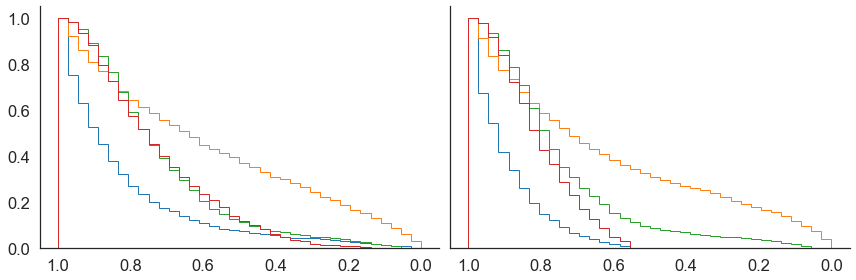

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data.csv').query('Study=="2018moutoussis"')

## Reduce to participants at both sessions.
data = data.groupby('Subject').filter(lambda x: x.Condition.nunique()==2)

## Compute accuracy within participants & sessions.
pre = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
pre['Cue'] = pre.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

## Compute fraction of participants with at least one bad session.
pivot = pre.pivot_table(index=('Subject','Condition'), columns='Cue', values='Accuracy')
pivot['R1'] = pivot['GW'] < 0.55
pivot['R2'] = pivot['NGAL'] < 0.55
pivot['R3'] = np.logical_or(pivot['R1'], pivot['R2'])
reject = pivot.groupby('Subject').R3.apply(lambda x: np.any(x))
print('Fraction of participants: %0.2f' %reject.mean())

## Reject participants.
data = data[~np.in1d(data.Subject, reject[reject].index)]
data.to_csv('preproc.csv', index=False)

## Compute accuracy within participants & sessions.
post = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
post['Cue'] = post.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
bins = np.linspace(0,1,37)

## Iteratively plot.
for ax, gb in zip(axes, [pre, post]):

    for c in ['GW','NGW','GAL','NGAL']:
        ax.hist(gb.query(f'Cue=="{c}"').Accuracy, bins=bins, density=True, cumulative=1, histtype='step')

ax.invert_xaxis()
sns.despine()
plt.tight_layout()

## Section 2: Prepare for Stan

In [3]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Randomly select.
ix = np.random.choice(data.Subject.unique(), 20, replace=False)
data = data[np.in1d(data.Subject, ix)]

## Define metadata.
N = data.Subject.nunique()
K = data.Condition.nunique()
T = data.Trial.nunique()

## Define data.
Y = data.pivot_table('Choice',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
X = data.pivot_table('Cue',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
R = data.pivot_table('Outcome',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)

## Assemble data.
dd = dict(N=N, T=T, Y=Y, X=X, R=R)

## Secttion 3:

In [4]:
import os, pystan
from stantools.io import load_model, save_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = f'pit_4arm_trt_m2'

## Sampling parameters.
samples = 1500
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
N = data.Subject.nunique()
K = data.Condition.nunique()
T = data.Trial.nunique()

## Define data.
Y = data.pivot_table('Choice',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
X = data.pivot_table('Cue',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
R = data.pivot_table('Outcome',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)

## Assemble data.
dd = dict(N=N, T=T, Y=Y, X=X, R=R)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Load StanModel
StanModel = load_model(os.path.join('stan_models',stan_model))

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=0)

## Save.
# save_fit(f, StanFit, data=dd)

In [5]:
samples = StanFit.extract()

rho = samples['rho']
eta = samples['eta']
tau = samples['tau']
nu  = samples['nu']
xi  = samples['xi']

corr = []
for i in range(N):
    
    for j in range(2):

        samples = np.stack([rho[:,i,j], eta[:,i,j], tau[:,i,j], nu[:,i,j], xi[:,i,j]])
        corr.append( np.corrcoef(samples) )
        
corr = np.stack(corr)

In [6]:
from pandas import DataFrame

summary = StanFit.summary()
summary = DataFrame(summary['summary'], columns=summary['summary_colnames'],
                    index=summary['summary_rownames'])

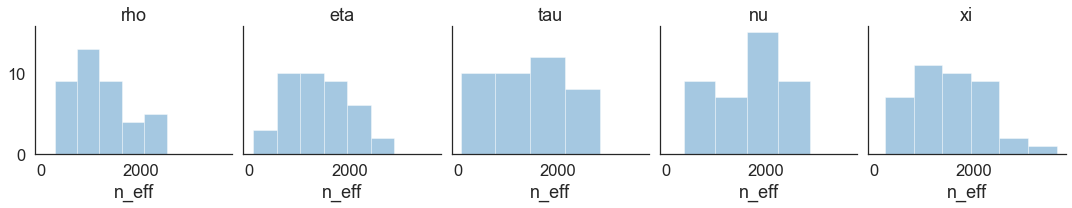

In [7]:
titles = ['rho','eta','tau','nu','xi']

fig, axes = plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=True)

for i, title in enumerate(titles):
    sns.distplot(summary.T.filter(regex=f'^{title}\[').T.n_eff, kde=False, ax=axes[i])
    axes[i].set(title=title)
sns.despine()
plt.tight_layout()

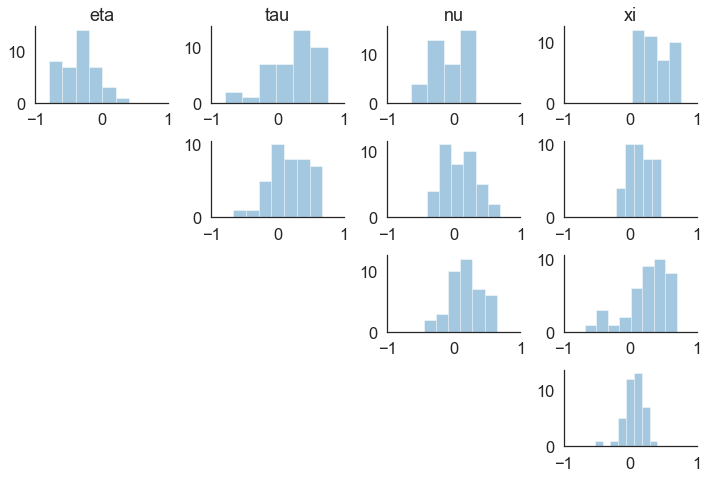

In [8]:
titles = ['rho','eta','tau','nu','xi']

plt.figure(figsize=(12,8))

for i in range(5):
    for j in range(i,5):
        if i == j: continue
        ax = plt.subplot2grid((5,5),(i,j))
        sns.distplot(corr[:,i,j], kde=False, ax=ax)
        ax.set(xlim=(-1,1))
        if not i: ax.set_title(titles[j])
            
sns.despine()
plt.tight_layout()

In [10]:
print(StanFit)

Inference for Stan model: anon_model_16f407624e5c589b49f649fdedd72854.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%     25%     50%     75%   97.5%  n_eff   Rhat
rho_c_pr[1]     0.88    0.02   0.61  -0.13    0.45    0.83    1.24    2.26   1522    1.0
rho_c_pr[2]      0.4    0.02   0.61   -0.5   -0.03    0.31    0.73    1.82   1329    1.0
rho_c_pr[3]    -0.51  9.7e-3   0.31   -1.0   -0.74   -0.55   -0.32    0.22   1047    1.0
rho_c_pr[4]     0.65    0.03   0.76  -0.68    0.13    0.59    1.12    2.32    638   1.01
rho_c_pr[5]    -0.55    0.02   0.47  -1.06   -0.86   -0.68   -0.39    0.62    473   1.01
rho_c_pr[6]     0.48    0.02   0.59  -0.45    0.06    0.39    0.83    1.83   1035    1.0
rho_c_pr[7]     1.14    0.01   0.64   0.07    0.67    1.09    1.53    2.53   1959    1.0
rho_c_pr[8]    -0.64    0.02   0.42  -1.13   -0.89   -0.73   -0.49    0.44    568    1.0
rho_c_pr[9]